In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL, einops
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

## Neural Cellular Automata

A cellular automaton is a discrete model that consists of a grid of cells, each of which can be in one of a finite number of states. The cells are updated simultaneously based on a set of rules that determine the state of a cell based on the states of its neighbors.

Cellular automata are often used to model complex systems and can exhibit emergent behavior, meaning that patterns and behaviors emerge from the interactions of the individual cells even though the rules governing their behavior are simple.

Classic examples such as the famous 'Game of Life' have very simple rules and limit states to 'alive' or 'dead'. However, the ideas can be extended to continuous outputs for each cell, and the update 'rule' can be a small neural network rather than a hard-coded decision tree - giving us 'Neural Cellular Automata'.

Here's what our NCA will look like:

![nca.png](images/nca.png)

Key references: 
- [Growing Neural Cellular Automata](https://distill.pub/2020/growing-ca/) - A delightful paper that was my intro to the topic

- [Texture Generation with NCA](https://arxiv.org/abs/2105.07299) - tiny models making amazing textures, the paper we're replicating today.

- ['The Future of Artificial Intelligence is Self-Organizing and Self-Assembling'](https://sebastianrisi.com/self_assembling_ai/) - More general discussion of this space

- [Fixing Neural CA Colors with Sliced Optimal Transport](https://www.youtube.com/watch?v=ZFYZFlY7lgI) -  A follow-on video from Alexander Mordvintsev (include code for a different style loss)

#### Match This Style with an NCA

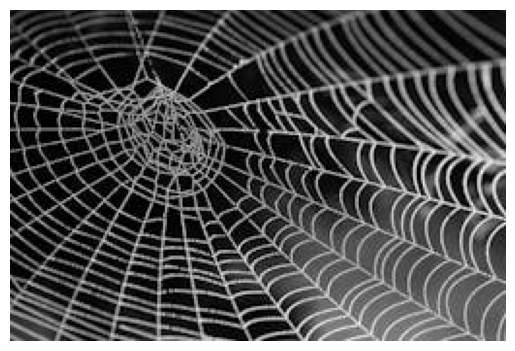

In [2]:
def download_image(url):
    imgb = fc.urlread(url, decode=False) 
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255.

url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"
style_im = download_image(url).to(def_device)
show_image(style_im);

#### Style Loss

In [3]:
vgg16 = timm.create_model('vgg16', pretrained=True).to(def_device).features
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def calc_features(imgs, target_layers=[18, 25]): 
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

def calc_grams(img, target_layers=[1, 6, 11, 18, 25]):
    return L(torch.einsum('bchw, bdhw -> cd', x, x) / (x.shape[-2]*x.shape[-1]) for x in calc_features(img, target_layers))

class StyleLossToTarget():
    def __init__(self, target_im, target_layers=[1, 6, 11, 18, 25]):
        fc.store_attr()
        with torch.no_grad(): 
            self.target_grams = calc_grams(target_im[None], target_layers)
    def __call__(self, input_im): 
        return sum((f1-f2).pow(2).mean() for f1, f2 in 
               zip(calc_grams(input_im, self.target_layers), self.target_grams))

In [4]:
style_loss = StyleLossToTarget(style_im)
style_loss(torch.rand(1, 3, 256, 256).to(def_device))

tensor(1169.4655, device='cuda:0', grad_fn=<AddBackward0>)

#### Defining NCA Model

In [5]:
num_channels = 4
hidden_n = 8

In [6]:
def make_grids(n, sz=128):
    return torch.zeros(n, num_channels, sz, sz).to(def_device)

In [7]:
filters = torch.stack([
    tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]]),
    tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]),
    tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]]).T,
    tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])
]).to(def_device)

In [8]:
def perchannel_conv(x, filters):
    '''filters: [filter_n, h, w]'''
    b, ch, h, w = x.shape
    y = x.reshape(b*ch, 1, h, w)
    y = F.pad(y, [1, 1, 1, 1], 'circular') # << Note pad mode
    y = F.conv2d(y, filters[:,None])
    return y.reshape(b, -1, h, w)

In [9]:
x = make_grids(1)
model_inputs = perchannel_conv(x, filters)
model_inputs.shape

torch.Size([1, 16, 128, 128])

In [10]:
brain = nn.Sequential(
    nn.Linear(num_channels*4, hidden_n),
    nn.ReLU(),
    nn.Linear(hidden_n, num_channels, bias=False)
).to(def_device)
model_inputs_flat = einops.rearrange(model_inputs, 'b c h w -> (b h w) c') # (1*128*128, 16)
brain_preds = brain(model_inputs_flat).reshape(x.shape)
brain_preds.shape

torch.Size([1, 4, 128, 128])

In [11]:
[p.shape for p in brain.parameters()]

[torch.Size([8, 16]), torch.Size([8]), torch.Size([4, 8])]

In [12]:
brain = nn.Sequential(
    nn.Conv2d(num_channels*4, hidden_n, 1),
    nn.ReLU(),
    nn.Conv2d(hidden_n, num_channels, 1, bias=False)
).to(def_device)
brain_preds = brain(model_inputs).reshape(x.shape)
brain_preds.shape

torch.Size([1, 4, 128, 128])

In [13]:
[p.shape for p in brain.parameters()]

[torch.Size([8, 16, 1, 1]), torch.Size([8]), torch.Size([4, 8, 1, 1])]

Putting this into a class, with a few extra features:
- Random update: only update ~50% of the cells 
- to_rgb function to scale and show the first 3 channels as an RGB image
- An option to zero out the weights of the second layer. Think: why is this useful?

In [14]:
class SimpleCA(nn.Module):
    def __init__(self, zero_w2=True):
        super().__init__()
        self.w1 = nn.Conv2d(num_channels*4, hidden_n, 1)
        self.relu = nn.ReLU()
        self.w2 = nn.Conv2d(hidden_n, num_channels, 1, bias=False)
        if zero_w2: self.w2.weight.data.zero_()


    def forward(self, x, update_rate=0.5):
        y = perchannel_conv(x, filters) # Apply the filters
        y = self.w2(self.relu(self.w1(y))) # pass the result through our 'brain'
        b, c, h, w = y.shape
        update_mask = (torch.rand(b, 1, h, w).to(x.device)+update_rate).floor() # Random update
        return x+y*update_mask

    def to_rgb(self, x):
        return x[...,:3,:,:]+0.5

#### Training

In [15]:
class LengthDataset():
    def __init__(self, length=1): self.length=length
    def __len__(self): return self.length
    def __getitem__(self, idx): return 0,0

def get_dummy_dls(length=100):
    return DataLoaders(DataLoader(LengthDataset(length), batch_size=1),
                       DataLoader(LengthDataset(1), batch_size=1))

In [16]:
class NCAProgressCB(ProgressCB):
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if not (hasattr(learn, 'metrics') and learn.training): return 
        self.losses.append(learn.loss.item())
        mbar = self.mbar
        if not hasattr(mbar, 'graph_fig'):
            mbar.graph_fig, mbar.graph_axs = plt.subplots(1, 2, figsize=(12, 3.5))
            mbar.graph_out = display(mbar.graph_fig, display_id=True)

        # Update preview image every 64 iters
        if (len(self.losses))%64 != 10: return 
        
        # Plot losses:
        mbar.graph_axs[0].clear()
        mbar.graph_axs[0].plot(self.losses, '.', alpha=0.3)
        mbar.graph_axs[0].set_yscale('log')
        mbar.graph_axs[0].set_ylim(tensor(self.losses).min(), self.losses[0])
        
        # Show preview images:
        rgb = learn.model.to_rgb(learn.preds.detach()).clip(0, 1)
        show_image(torchvision.utils.make_grid(rgb), ax=mbar.graph_axs[1])
        
        # Update graph
        mbar.graph_out.update(mbar.graph_fig)

In [17]:
class NCACB(TrainCB):
    order = DeviceCB.order+1
    def __init__(self, ca, style_img_tensor, style_loss_scale=0.1, size=256, 
                 step_n_min=32, step_n_max=96, batch_size=4):
        fc.store_attr()
        with torch.no_grad(): self.pool = make_grids(256, sz=size) # Set up a 'pool' of grids
    
    def predict(self, learn): 
        
        # Pick some random samples from the pool
        batch_idx = torch.randint(0, len(self.pool), (self.batch_size,))
        x = self.pool[batch_idx]
        
        # occasionally zero out some samples
        if torch.randint(8, (1,)) < 1: 
            x[:1] =  make_grids(1, sz=self.size)
        
        # Apply the model a number of times
        for _ in range(torch.randint(self.step_n_min, self.step_n_max, (1,))):
            x = learn.model(x)
        
        # Update pool
        with torch.no_grad(): self.pool[batch_idx] = x
        
        # and store preds
        learn.preds = x
        
    def get_loss(self, learn): 
        style_loss = learn.loss_func(learn.model.to_rgb(self.learn.preds))
        overflow_loss = (learn.preds-learn.preds.clamp(-1.0, 1.0)).abs().sum()
        learn.loss = overflow_loss + style_loss*self.style_loss_scale
        
    def backward(self, learn):
        learn.loss.backward()
        # Gradient normalization:
        for p in learn.model.parameters():
            p.grad /= (p.grad.norm()+1e-8) 
        
    def before_fit(self, learn): self.learn=learn 

In [18]:
model = SimpleCA().to(def_device)
cbs = [NCACB(model, style_im), NCAProgressCB(), MetricsCB()]
style_loss = StyleLossToTarget(style_im)

learn = Learner(model, get_dummy_dls(1200), style_loss, lr=1e-3, cbs=cbs, opt_func=torch.optim.Adam)

loss,epoch,train
1894.423,0,train
32.741,0,eval


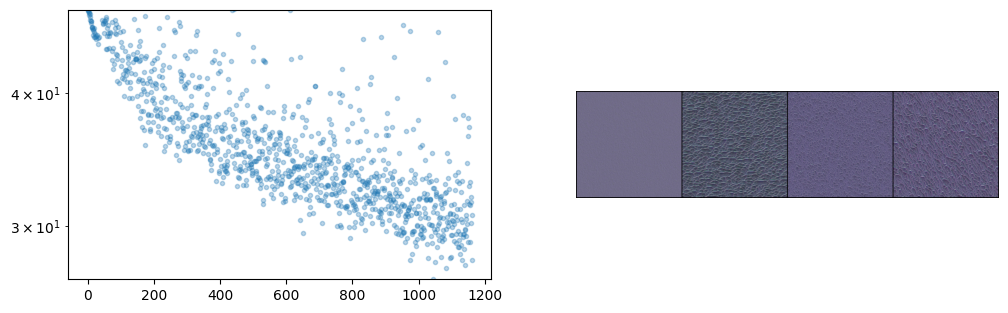

In [19]:
learn.fit(1)

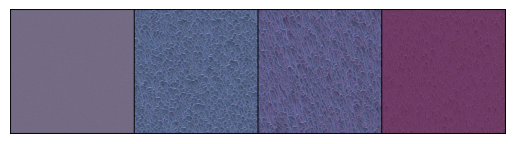

In [20]:
rgb = model.to_rgb(learn.preds.detach())
rgb = torchvision.utils.make_grid(rgb)
show_image(rgb.clip(0, 1));

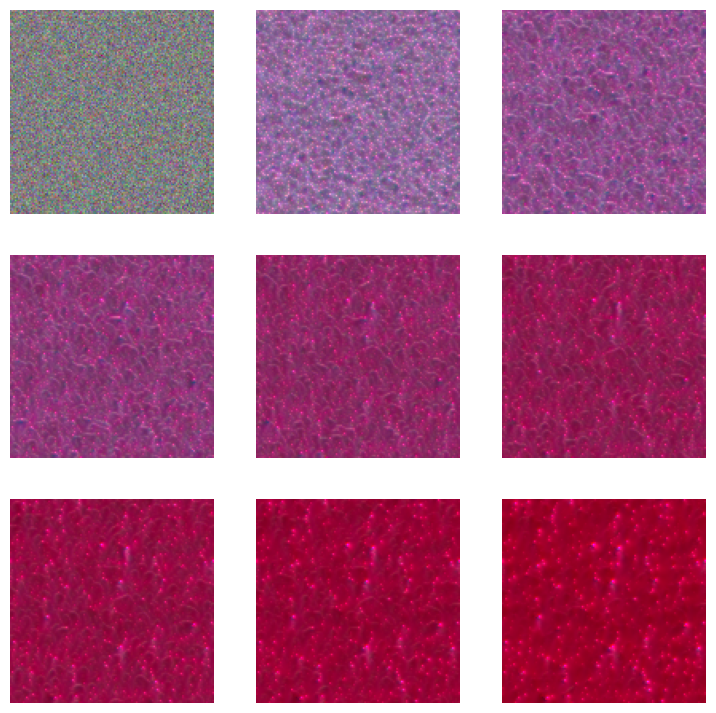

In [21]:
images = []
x = torch.randn(1, num_channels, 128, 128).to(def_device) * 0.1
for i in range(900):
    x = model(x)
    if i%100==0: images.append(model.to_rgb(x)[0].clip(0, 1))
show_images(images)

In [22]:
sum(p.numel() for p in model.parameters())

168